In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from collections import Counter

# Loads datasets

In [95]:
# Loads processed pay datasets
dfGrad = pd.read_csv('processed_datasets/pay_data_grads_only.csv', )
dfGradGrouped = pd.read_csv('processed_datasets/pay_data_emplid_grouped.csv')
dfDeptSplit = pd.read_csv('processed_datasets/pay_data_dept_split.csv')

print('dfGrad columns:', dfGrad.columns)
print()
print('dfGradGrouped columns:', dfGradGrouped.columns)
print()
print('dfDeptSplit columns:', dfDeptSplit.columns)

dfGrad columns: Index(['Day Date', 'Normalized Hourly Base Rate', 'Salary Grade',
       'Minimum Hourly Rate', 'Midpoint Hourly Rate', 'Maximum Hourly Rate',
       'Compa Ratio', 'Normalized Annual Base Salary', 'Calculated Annual P12',
       'Calculated Annual P10', 'Calculated Annual P09',
       'Employee Record Number', 'Job Code - Job Title', 'Job Code Start Date',
       'Years in Job Code', 'University Start Date', 'Years at the University',
       'Paygroup', 'Empl Class', 'Standard Hours', 'College/Admin Unit',
       'ZDeptID', 'Department', 'Emplid_Anon', 'emplid_anon + snapshot'],
      dtype='object')

dfGradGrouped columns: Index(['Date', 'Emplid_Anon', 'Hours_total', 'Hours_list', 'Hourly_rate_list',
       'Annual_P09_list', 'Annual_P12_list', 'Department_list', 'College_list',
       'Num_appts', 'Yearly_pay_total_no_summer',
       'Yearly_pay_total_with_summer', 'Eff_hourly_wage_20hr',
       'Eff_hourly_wage_40hr'],
      dtype='object')

dfDeptSplit columns: Ind

In [59]:
# Selects the college codes corresponding to acadmic colleges (as opposed to administrative units)
# These match the colleges listed on the UMN website at https://twin-cities.umn.edu/academics-admissions/colleges-and-schools

collegeCodesToUse = {'TCBS','TUCL','TDEN','TALA','TCED','TEXT','TCOA','TLAW','TCLA','TCSM','TNUR','TPHR','THHH','TPUB','TIOT','TVET','TMED'}

In [96]:
# Loads inflation data
dfMPLSInflation = pd.read_csv('MPLS_inflation.txt')

# Conversion factors into 2015 dollars
year2InflationIdx2015 = {year: idx for year, idx in zip(dfMPLSInflation['Year'].values, dfMPLSInflation['Inflation_index'].values)}
year2InflationIdx2015[2022] = np.nan
print(year2InflationIdx2015)

# Conversion factors into 2021 dollars
year2InflationIdx2021 = {y: year2InflationIdx2015[y]/year2InflationIdx2015[2021] for y in year2InflationIdx2015}

{2015: 1.0, 2016: 1.01552, 2017: 1.03761, 2018: 1.06246, 2019: 1.08474, 2020: 1.09728, 2021: 1.1504, 2022: nan}


In [97]:
# Date formatting & calculations

dates = list(sorted(set(dfDeptSplit['Date'].values)))
dateObjs = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
dateOrds = [dateObj.toordinal() for dateObj in dateObjs]
dateYears = [dateObj.year for dateObj in dateObjs]
datesPretty = [dateObj.strftime('%b %Y') for dateObj in dateObjs]

mostRecentDate = dates[-1]

# Plots (data-oriented)

Text(0.5, 1.0, 'Mean yearly wage for a standard (50%) appointment, by college (2021 dollars)\n(Assumes NO summer support)')

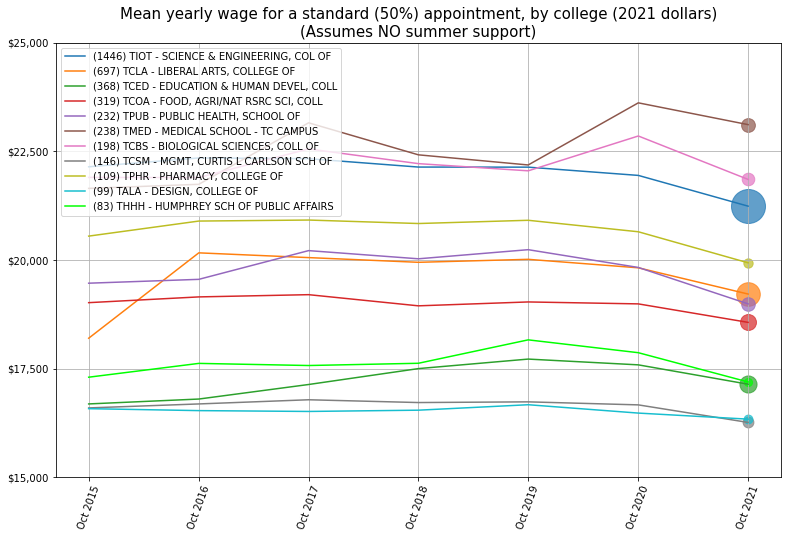

In [98]:
# Creates lists of the YEARLY wages of students with 20 hour appointments in each college

assumeSummerSupport = False
adjustForInflation = True

colleges = set(dfDeptSplit['College'].values)
cond20HrAppts = (dfDeptSplit['Hours_total']==20)

stipendCol = 'Yearly_pay_total_with_summer' if assumeSummerSupport else 'Yearly_pay_total_no_summer'
collegeDate2WageDistrib = {
    (college,date): dfDeptSplit[cond20HrAppts & (dfDeptSplit['College']==college) & (dfDeptSplit['Date']==date)][stipendCol].values
    / (year2InflationIdx2021[dateYears[dateIdx]] if adjustForInflation else 1.)
    for college in colleges for (dateIdx, date) in enumerate(dates)
}

# Plot: Mean yearly wages for students in each college, assuming/not assuming summer support

useMedian = False
minimumCollegeSize = 0

collegeRowCounts = {c: np.sum(dfDeptSplit['College']==c) for c in colleges}
collegeCurrCounts = {c: np.sum((dfDeptSplit['College']==c) & (dfDeptSplit['Date']==mostRecentDate)) for c in colleges}
collegeListSorted = list(sorted(colleges, key=lambda c: collegeRowCounts[c], reverse=True))
biggestCurrColleges = collegeListSorted[:11]
biggestCurrColleges_WageSorted = list(sorted(biggestCurrColleges, key=lambda c: np.median(collegeDate2WageDistrib[(c, mostRecentDate)]), reverse=True))

# Takes the indices of all October dates
dateIndicesToPlot = [i for i in range(len(dates)) if dates[i][5:7]=='10']
datesToPlot = [dates[i] for i in dateIndicesToPlot]
dateOrdsToPlot = [dateOrds[i] for i in dateIndicesToPlot]
dateYearsToPlot = [dateYears[i] for i in dateIndicesToPlot]
datesPrettyToPlot = [datesPretty[i] for i in dateIndicesToPlot]

plt.figure(figsize=(13,8)).patch.set_facecolor('w')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ['#00FF00']

for collegeIdx, college in enumerate(biggestCurrColleges_WageSorted):
    
    if useMedian:
        wagesOverTime = [np.median(collegeDate2WageDistrib[(college,date)]) if len(collegeDate2WageDistrib[(college,date)])>=minimumCollegeSize else np.nan for date in datesToPlot]
    else:
        wagesOverTime = [np.mean(collegeDate2WageDistrib[(college,date)]) if len(collegeDate2WageDistrib[(college,date)])>=minimumCollegeSize else np.nan for date in datesToPlot]
    plt.plot(dateOrdsToPlot, wagesOverTime, label='(%i) %s' % (collegeCurrCounts[college], college), color=colors[collegeIdx])
    plt.scatter([dateOrdsToPlot[-1]], [wagesOverTime[-1]], s=collegeCurrCounts[college]*0.8, color=colors[collegeIdx], alpha=0.7)

# plt.ylim(15, 35)
plt.xticks(ticks=dateOrdsToPlot, labels=datesPrettyToPlot, rotation=70)
if assumeSummerSupport:
    plt.yticks([17500, 20000, 22500, 25000, 27500, 30000], ['$17,500', '$20,000', '$22,500', '$25,000', '$27,500', '$30,000'])
else:
    plt.yticks([15000, 17500, 20000, 22500, 25000], ['$15,000', '$17,500', '$20,000', '$22,500', '$25,000'])
plt.legend()
plt.grid(axis='both')

summerSupportStr = '(Assumes '+('FULL' if assumeSummerSupport else 'NO')+' summer support)'
inflationStr = ' (2021 dollars)' if adjustForInflation else ''
plt.title(('Median' if useMedian else 'Mean')+' yearly wage for a standard (50%) appointment, by college'+inflationStr+'\n'+summerSupportStr, fontsize=15)

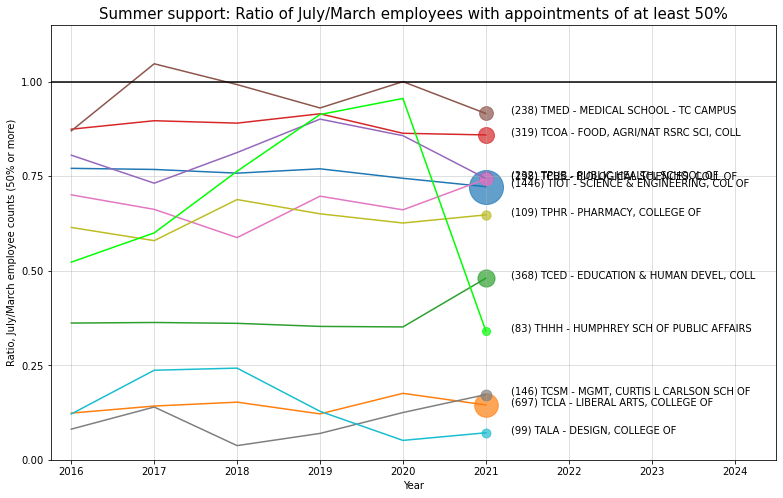

In [99]:
# Summer support plots for each college. Will estimate as "July emplids"/"Oct emplids"

# Maps year -> index of the date in that year corresponding to the given month (July or March)
marYear2Index = {dateYears[i]:i for i in range(len(dates)) if dates[i][5:7]=='03'}
julYear2Index = {dateYears[i]:i for i in range(len(dates)) if dates[i][5:7]=='07'}
sharedYears = list(sorted([y for y in julYear2Index.keys() if y in marYear2Index.keys()]))
marYear2Index = {y:i for y,i in marYear2Index.items() if y in sharedYears}
julYear2Index = {y:i for y,i in julYear2Index.items() if y in sharedYears}

# Selects the colleges to plot
collegeRowCounts = {c: np.sum(dfDeptSplit['College']==c) for c in colleges}
collegeCurrCounts = {c: np.sum((dfDeptSplit['College']==c) & (dfDeptSplit['Date']==mostRecentDate)) for c in colleges}
collegeListSorted = list(sorted(colleges, key=lambda c: collegeRowCounts[c], reverse=True))
biggestCurrColleges = collegeListSorted[:11]

# Plot: Ratio of (July 50%+ emplid count / March 50%+ emplid count) each year
plt.figure(figsize=(13,8)).patch.set_facecolor('w')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ['#00FF00']

for collegeIdx, college in enumerate(biggestCurrColleges):
    marApptCounts = np.array([np.sum(
        (dfDeptSplit['Hours_total'] >= 20) &
        (dfDeptSplit['College'] == college) &
        (dfDeptSplit['Date'] == dates[marYear2Index[year]])
    ) for year in sharedYears])
    
    julApptCounts = np.array([np.sum(
        (dfDeptSplit['Hours_total'] >= 20) &
        (dfDeptSplit['College'] == college) &
        (dfDeptSplit['Date'] == dates[julYear2Index[year]])
    ) for year in sharedYears])
    
    summerApptFracs = julApptCounts / marApptCounts
    label = '(%i) %s' % (collegeCurrCounts[college], college)
    plt.plot(sharedYears, summerApptFracs, color=colors[collegeIdx], label=label)
    plt.scatter([sharedYears[-1]], [summerApptFracs[-1]], s=collegeCurrCounts[college]*0.8, color=colors[collegeIdx], alpha=0.7)
    plt.text(sharedYears[-1]+0.3, summerApptFracs[-1], label)

plt.xlim(sharedYears[0]-0.25, sharedYears[-1]+3.5)
plt.ylim(0,1.15)
plt.xlabel('Year')
plt.ylabel('Ratio, July/March employee counts (50% or more)')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.axhline(1, color='k')
plt.grid(axis='both', alpha=0.5)
# plt.legend()
plt.title('Summer support: Ratio of July/March employees with appointments of at least 50%', fontsize=15)
plt.show()


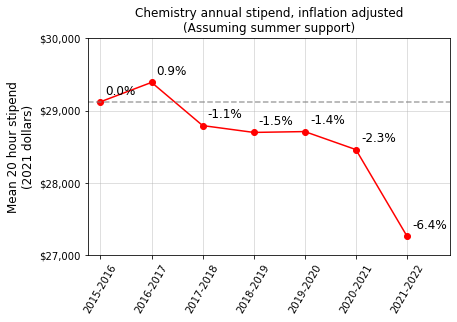

In [100]:
# Plots the trend for an individual department/program

targetDept, targetDeptShortname = '11098 - CSENG Chemistry Administration', 'Chemistry'
# targetDept, targetDeptShortname = '11140 - CSENG Physics & Astron,Schl of', 'SPA'

dfDept = dfDeptSplit[dfDeptSplit['Department'] == targetDept]

yearlyMeanPayDept = []
years = np.arange(2015, 2021+1)
for year in years:
    dfDeptSelection = dfDept[
        (dfDept['Date'] == str(year)+'-10-15') &
        (dfDept['Hours_total'] == 20)
    ]
    yearlyMeanPayDept.append(
        np.mean(dfDeptSelection['Yearly_pay_total_with_summer']) / year2InflationIdx2021[year]
    )

yearlyMeanPayDept = np.array(yearlyMeanPayDept)

plt.figure(figsize=(6.5, 4)).patch.set_facecolor('w')
plt.plot(years, yearlyMeanPayDept, color='r', marker='o')
for i in range(len(yearlyMeanPayDept)):
    pctChange = 100*(yearlyMeanPayDept[i] - yearlyMeanPayDept[0])/(yearlyMeanPayDept[0])
    plt.text(years[i]+0.1, yearlyMeanPayDept[i]+100, '%.1f%%'%pctChange, fontsize=12)
plt.xticks(years, labels=['%i-%i' % (y, y+1) for y in years], rotation=60)
plt.xlim(years[0]-0.25, years[-1]+0.85)
plt.yticks([27000, 28000, 29000, 30000], ['$27,000', '$28,000', '$29,000', '$30,000'])
plt.grid(alpha=0.5)
plt.ylabel('Mean 20 hour stipend\n(2021 dollars)', fontsize=12)
plt.title('%s annual stipend, inflation adjusted\n(Assuming summer support)' % targetDeptShortname)
plt.axhline(yearlyMeanPayDept[0], color='gray', linestyle='--', alpha=0.7)


/home/nico/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


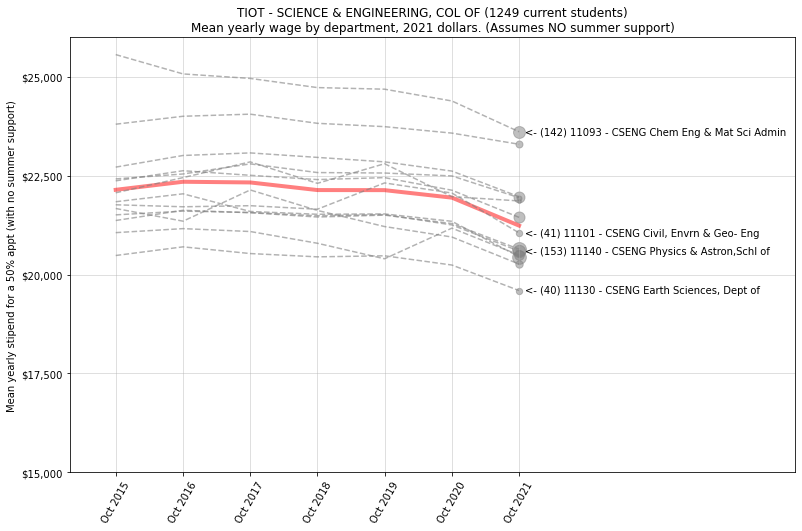

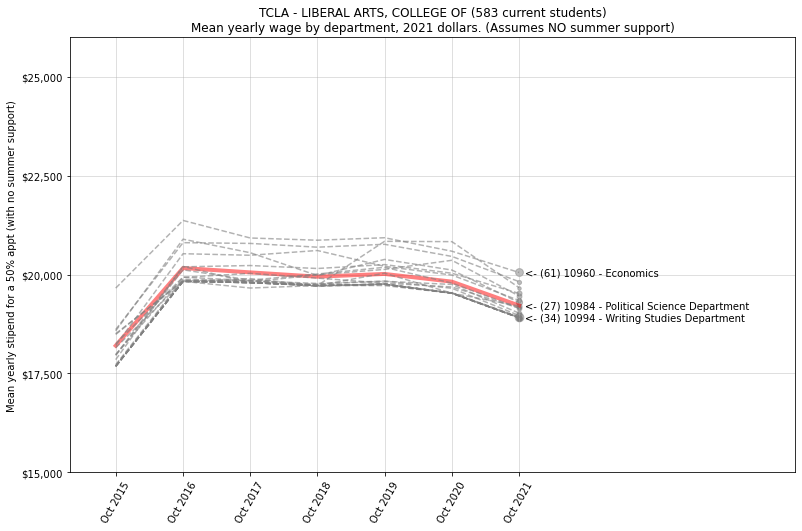

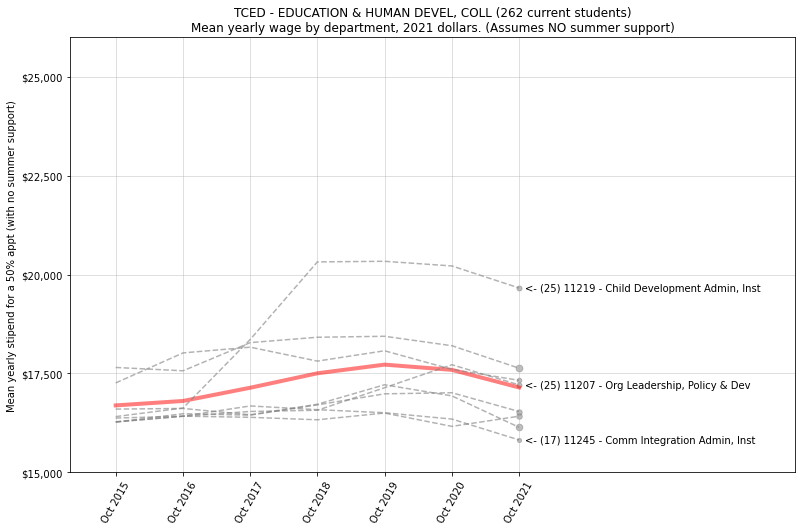

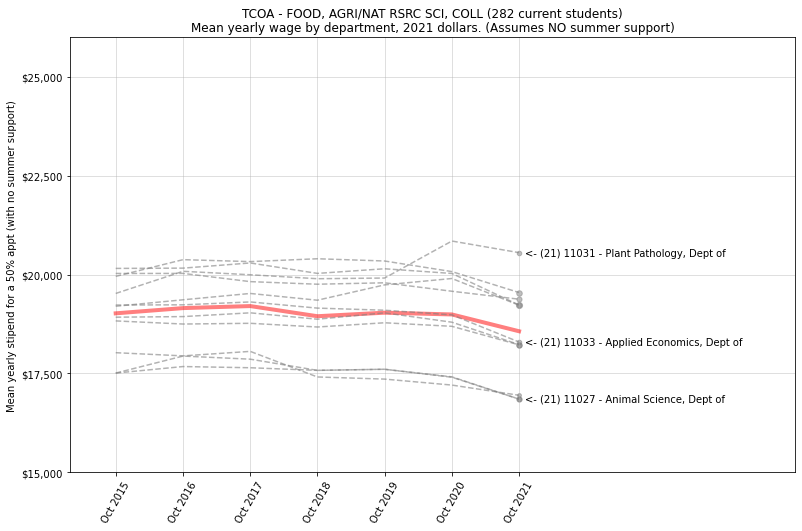

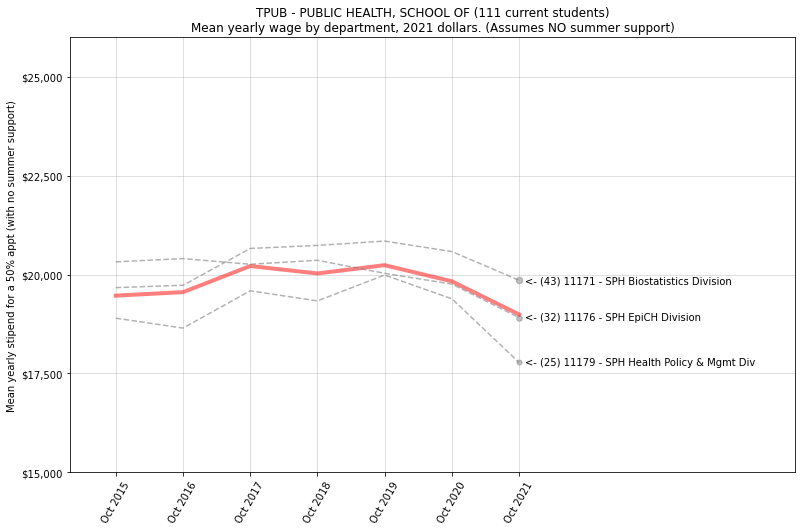

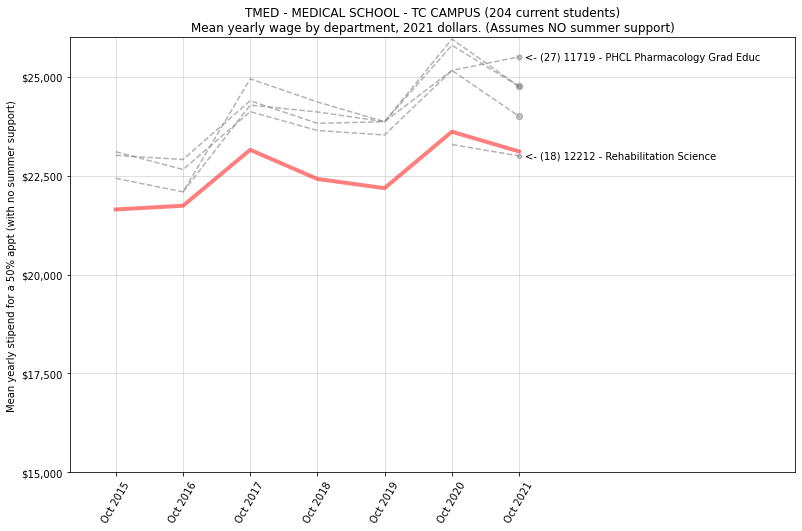

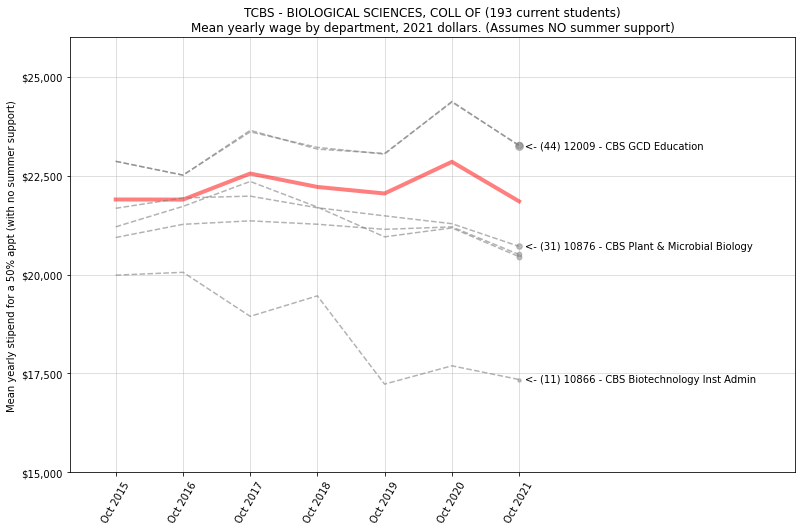

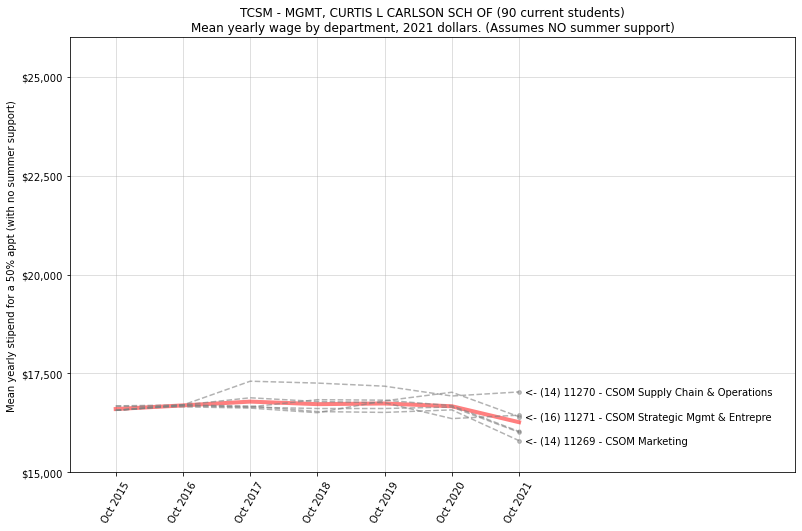

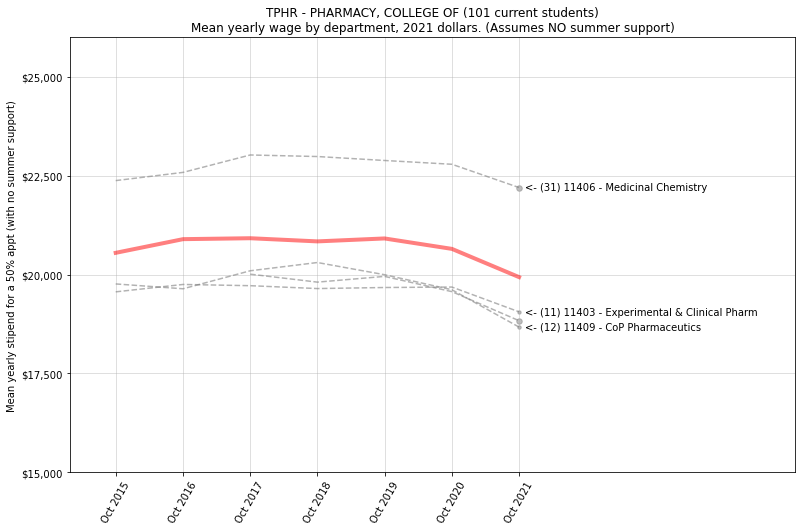

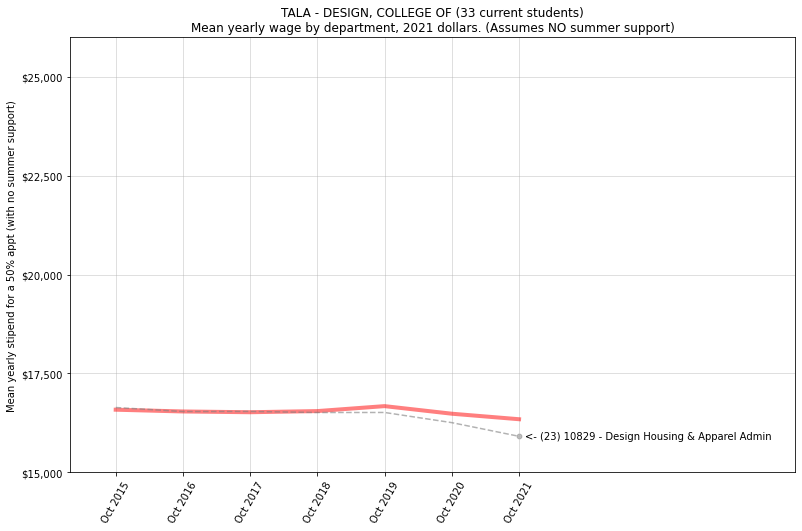

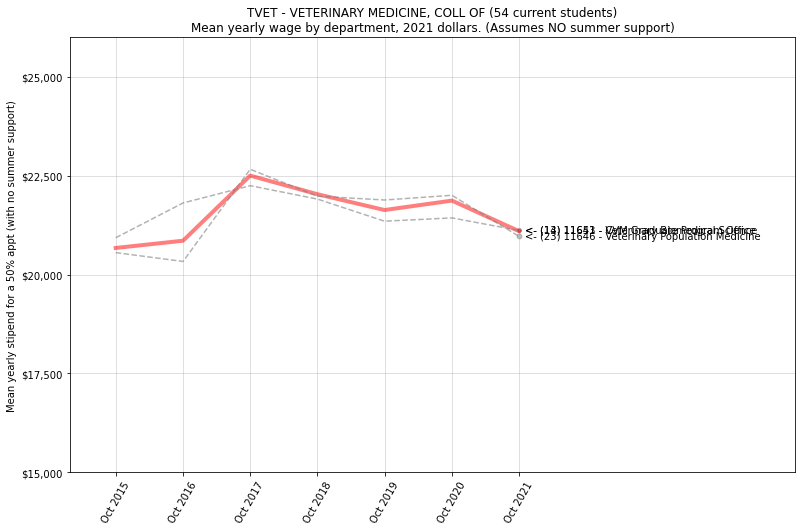

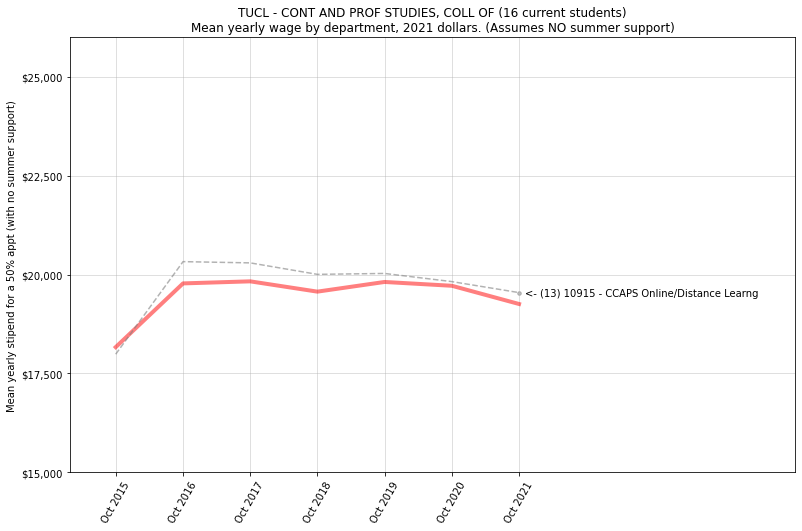

In [101]:
deptMinSize = 10
adjustForInflation = True
assumeSummerSupport = False

stipendCol = 'Yearly_pay_total_with_summer' if assumeSummerSupport else 'Yearly_pay_total_no_summer'

# Takes the indices of all October dates
dateIndicesToPlot = [i for i in range(len(dates)) if dates[i][5:7]=='10']
datesToPlot = [dates[i] for i in dateIndicesToPlot]
dateOrdsToPlot = [dateOrds[i] for i in dateIndicesToPlot]
dateYearsToPlot = [dateYears[i] for i in dateIndicesToPlot]
datesPrettyToPlot = [datesPretty[i] for i in dateIndicesToPlot]

# Select a set of colleges to focus on

college2Size = {c: np.sum(dfDeptSplit['College']==c) for c in set(dfDeptSplit['College'].values)}
collegeCode2Name = {c[:4]: c for c in college2Size.keys()}
collegeCode2Size = {c[:4]: s for c,s in college2Size.items()}

collegeCode2SizeFilt = {code: s for code,s in collegeCode2Size.items() if code in collegeCodesToUse}
college2SizeFilt = {collegeCode2Name[code]: s for code,s in collegeCode2Size.items() if code in collegeCodesToUse}

collegeCodesSizeSorted = sorted([(code, size) for (code, size) in collegeCode2SizeFilt.items()], key=lambda t:-t[1])

for code, collegeSize in collegeCodesSizeSorted:
    dfDeptSplitCollege20hr = dfDeptSplit[
        (dfDeptSplit['College_code'] == code) &
        (dfDeptSplit['Hours_total'] == 20)
    ]
    
    depts = set(dfDeptSplitCollege20hr['Department'].values)
    
    deptDate2WageDistrib = {
        (dept,date): dfDeptSplitCollege20hr[(dfDeptSplitCollege20hr['Department']==dept) & (dfDeptSplitCollege20hr['Date']==date)][stipendCol].values
        for dept in depts for date in dates
    }

    # Creates a list of (dept, dept size, dept mean wage) for the most recent date
    mostRecentDate = datesToPlot[-1]
    latestDeptSizeWage = [(
        d, # Dept
        len(deptDate2WageDistrib[(d, mostRecentDate)]), # Dept size
        np.mean(deptDate2WageDistrib[(d, mostRecentDate)]) # Dept mean wage
    ) for d in depts]
    
    # Sorts the (dept, size, wage) list by wage, and filters by size
    latestDeptSizeWage_WageSorted_SizeFilt = list(sorted([
        (dept, size, wage) for (dept, size, wage) in latestDeptSizeWage if (size >= deptMinSize)
    ], key=lambda deptSizeWage: deptSizeWage[2], reverse=True))
    
    # No departments large enough to plot: Skips this college
    if len(latestDeptSizeWage_WageSorted_SizeFilt)==0: continue 
    
    # Creates the figure
    plt.figure(figsize=(13,8)).patch.set_facecolor('w')
    
    # Plots the college-level wage statistics
    collegeWageDistrib = [
        dfDeptSplitCollege20hr[(dfDeptSplitCollege20hr['College_code']==code) & (dfDeptSplitCollege20hr['Date']==date)][stipendCol].values
        / (year2InflationIdx2021[dateYearsToPlot[dateIdx]] if adjustForInflation else 1.)
        for dateIdx, date in enumerate(datesToPlot)
    ]
    wagesOverTimeCollege = [np.mean(wageDistrib) for wageDistrib in collegeWageDistrib]
    plt.plot(dateOrdsToPlot, wagesOverTimeCollege, color='r', linestyle='-', linewidth=4, alpha=0.5)
    
    # Determines the index of the department whose current wage is closest to the college mean
    closestToMeanIdx = np.argmin([np.abs(wage - wagesOverTimeCollege[-1]) for (dept,size,wage) in latestDeptSizeWage_WageSorted_SizeFilt])
    
    # Plots each individual department
    for idx, (dept,size,wage) in enumerate(latestDeptSizeWage_WageSorted_SizeFilt):
        wagesOverTime = [
            np.mean(deptDate2WageDistrib[(dept,date)])
            / (year2InflationIdx2021[dateYearsToPlot[dateIdx]] if adjustForInflation else 1.)
            for dateIdx, date in enumerate(datesToPlot)]
        plt.plot(dateOrdsToPlot, wagesOverTime, label=dept, alpha=0.6, color='gray', linestyle='--')
        plt.scatter([dateOrdsToPlot[-1]], [wage], s=size, alpha=0.5, color='gray')
        
        addTextCond = (idx==0) or (idx==len(latestDeptSizeWage_WageSorted_SizeFilt)-1) or (idx==closestToMeanIdx)
        addTextCond |= (latestDeptSizeWage_WageSorted_SizeFilt[idx][0] == '11140 - CSENG Physics & Astron,Schl of')
        if addTextCond:
            plt.text(dateOrdsToPlot[-1]+30, wage, '<- (%i) %s'%(size,dept), verticalalignment='center')
        
    
    # plt.scatter([dateOrdsToPlot[-1]], [wagesOverTimeCollege[-1]], s=size, alpha=0.5, color='')
    
    summerSupportStr = '(Assumes full summer support)' if assumeSummerSupport else '(Assumes NO summer support)'
    plt.title('%s (%i current students)\nMean yearly wage by department, 2021 dollars. %s' % (collegeCode2Name[code], len(collegeWageDistrib[-1]), summerSupportStr))
    plt.xticks(dateOrdsToPlot, labels=datesPrettyToPlot, rotation=60)
    plt.ylabel('Mean yearly stipend for a 50% appt (with no summer support)')
    plt.xlim(dateOrdsToPlot[0]-250, dateOrdsToPlot[-1]+1500)
    if assumeSummerSupport:
        plt.yticks([20000, 22500, 25000, 27500, 30000, 32500], ['$20,000', '$22,500', '$25,000', '$27,500', '$30,000', '$32,500'])
        # plt.ylim(20000, 34000)
        plt.ylim(25000, 34000)
    else:
        plt.yticks([15000, 17500, 20000, 22500, 25000], ['$15,000', '$17,500', '$20,000', '$22,500', '$25,000'])
        plt.ylim(15000, 26000)
    plt.grid(alpha=0.5)
    plt.show()


# Plots (presentation-oriented)

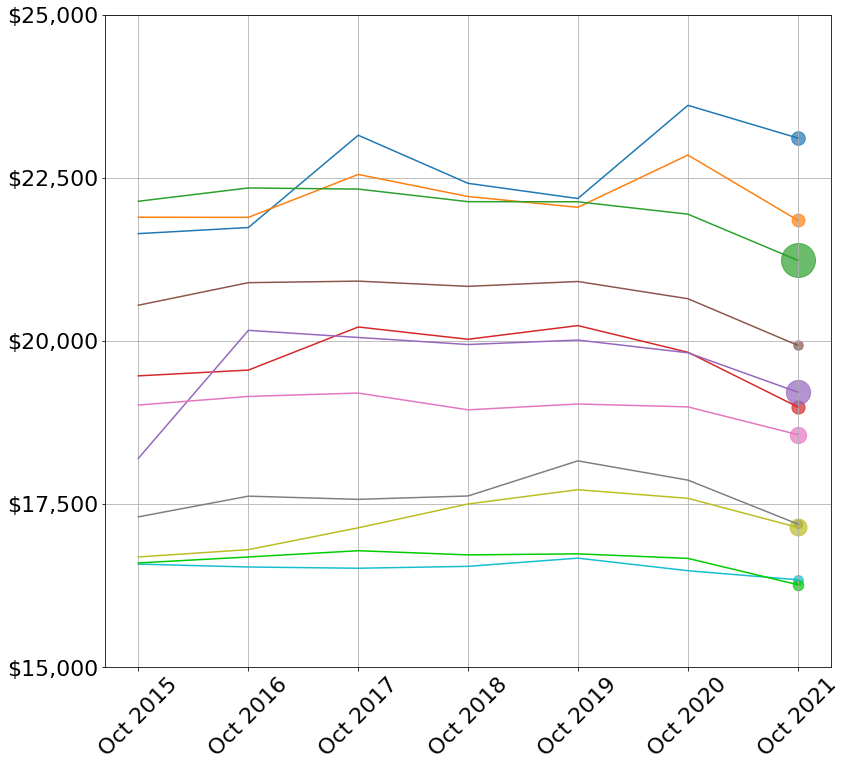

In [102]:
# For March 17, 2022 COGS GA: Inflation-adjusted pay by college over time

# Creates lists of the YEARLY wages of students with 20 hour appointments in each college

assumeSummerSupport = False
adjustForInflation = True
axisFontsize = 22
titleFontsize = 28

colleges = set(dfDeptSplit['College'].values)
cond20HrAppts = (dfDeptSplit['Hours_total']==20)

stipendCol = 'Yearly_pay_total_with_summer' if assumeSummerSupport else 'Yearly_pay_total_no_summer'
collegeDate2WageDistrib = {
    (college,date): dfDeptSplit[cond20HrAppts & (dfDeptSplit['College']==college) & (dfDeptSplit['Date']==date)][stipendCol].values
    / (year2InflationIdx2021[dateYears[dateIdx]] if adjustForInflation else 1.)
    for college in colleges for (dateIdx, date) in enumerate(dates)
}

# Plot: Mean yearly wages for students in each college, assuming/not assuming summer support

useMedian = False
minimumCollegeSize = 0

collegeRowCounts = {c: np.sum(dfDeptSplit['College']==c) for c in colleges}
collegeCurrCounts = {c: np.sum((dfDeptSplit['College']==c) & (dfDeptSplit['Date']==mostRecentDate)) for c in colleges}
collegeListSorted = list(sorted(colleges, key=lambda c: collegeRowCounts[c], reverse=True))
biggestCurrColleges = collegeListSorted[:11]
biggestCurrColleges_WageSorted = list(sorted(biggestCurrColleges, key=lambda c: np.median(collegeDate2WageDistrib[(c, mostRecentDate)]), reverse=True))

# Takes the indices of all October dates
dateIndicesToPlot = [i for i in range(len(dates)) if dates[i][5:7]=='10']
datesToPlot = [dates[i] for i in dateIndicesToPlot]
dateOrdsToPlot = [dateOrds[i] for i in dateIndicesToPlot]
dateYearsToPlot = [dateYears[i] for i in dateIndicesToPlot]
datesPrettyToPlot = [datesPretty[i] for i in dateIndicesToPlot]

plt.figure(figsize=(13,12)).patch.set_facecolor('w')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ['#00CC00']

for collegeIdx, college in enumerate(biggestCurrColleges_WageSorted):
    
    if useMedian:
        wagesOverTime = [np.median(collegeDate2WageDistrib[(college,date)]) if len(collegeDate2WageDistrib[(college,date)])>=minimumCollegeSize else np.nan for date in datesToPlot]
    else:
        wagesOverTime = [np.mean(collegeDate2WageDistrib[(college,date)]) if len(collegeDate2WageDistrib[(college,date)])>=minimumCollegeSize else np.nan for date in datesToPlot]
    plt.plot(dateOrdsToPlot, wagesOverTime, label='(%i) %s' % (collegeCurrCounts[college], college), color=colors[collegeIdx])
    plt.scatter([dateOrdsToPlot[-1]], [wagesOverTime[-1]], s=collegeCurrCounts[college]*0.8, color=colors[collegeIdx], alpha=0.7)

# plt.ylim(15, 35)
plt.xticks(ticks=dateOrdsToPlot, labels=datesPrettyToPlot, rotation=45, fontsize=axisFontsize)
if assumeSummerSupport:
    plt.yticks([17500, 20000, 22500, 25000, 27500, 30000], ['$17,500', '$20,000', '$22,500', '$25,000', '$27,500', '$30,000'], fontsize=axisFontsize)
else:
    plt.yticks([15000, 17500, 20000, 22500, 25000], ['$15,000', '$17,500', '$20,000', '$22,500', '$25,000'], fontsize=axisFontsize)
plt.grid(axis='both')

# plt.title('In 2021 dollars: Average salary for a 50% appointment', fontsize=titleFontsize)
plt.show()


In [76]:
for c in colors: print(c)

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b
#e377c2
#7f7f7f
#bcbd22
#17becf
#00CC00
